In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import scipy
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
color_back = 'lightgray'
color_front = 'mediumseagreen'
SEED=42
data_folder = '../data/'

from IPython.display import clear_output

pd.options.display.max_rows = 500
pd.options.display.max_columns = 500
pd.options.display.width = 2000
pd.options.display.max_colwidth = 2000
import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(data_folder + 'raw/multiple_choice_responses.csv', header=1)
_ = df.pop('Duration (in seconds)')

df.rename(columns={'What is your gender? - Selected Choice': 'Gender'}, inplace=True)
country_col = 'In which country do you currently reside?'
df.loc[df[country_col]=='United States of America', country_col] = 'USA'
df.loc[df[country_col]=='United Kingdom of Great Britain and Northern Ireland', country_col] = 'UK'
df.loc[df[country_col]=='Iran, Islamic Republic of...', country_col] = 'Iran'

job_title_col = 'Select the title most similar to your current role (or most recent title if retired): - Selected Choice'

# Gender ratio

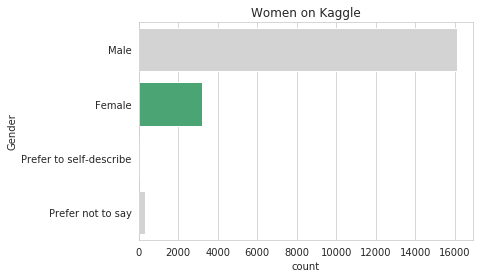

In [3]:
sns.countplot(y='Gender', data=df, palette=[color_back, color_front, color_back, color_back])
plt.title('Women on Kaggle');

# Gender ratio across countries

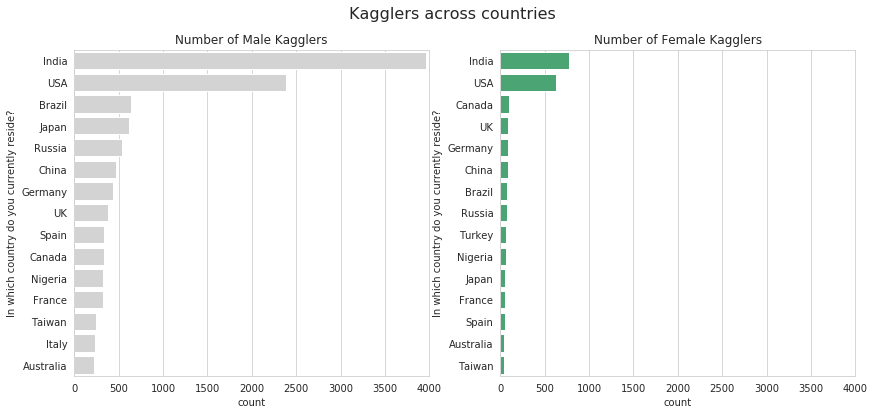

In [4]:
df = df.loc[df['Gender'].isin(['Female', 'Male'])]
df_women_countries = df.loc[df['Gender']=='Female', :]
df_women_countries = df_women_countries.loc[df_women_countries[country_col]!='Other', :]

df_men_countries = df.loc[df['Gender']=='Male', :]
df_men_countries = df_men_countries.loc[df_men_countries[country_col]!='Other', :]

fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(1, 2, 1)
sns.countplot(y=country_col, 
              data=df_men_countries, 
              order=df_men_countries[country_col].value_counts().iloc[:15].index, 
              color=color_back)
ax1.set_xlim(0, 4000)
ax1.set_title('Number of Male Kagglers');

ax2 = fig.add_subplot(1, 2, 2)
sns.countplot(y=country_col, 
              data=df_women_countries, 
              order=df_women_countries[country_col].value_counts().iloc[:15].index, 
              color=color_front)
ax2.set_xlim(0, 4000)
ax2.set_title('Number of Female Kagglers')
plt.suptitle('Kagglers across countries', fontsize=16);

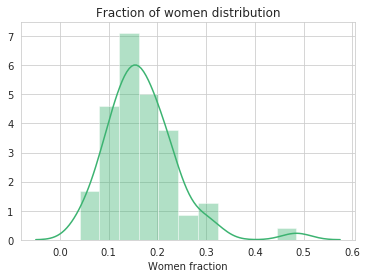

In [5]:
df_country_count = pd.DataFrame(df[country_col].value_counts())
df_country_count.rename(columns={'index': 'Country', country_col: 'Count'}, inplace=True)

df_women_country_count = pd.DataFrame(df.loc[df['Gender']=='Female', country_col].value_counts())
df_women_country_count.rename(columns={'index': 'Country', country_col: 'Women count'}, inplace=True)

df_country_count = df_country_count.join(df_women_country_count)
df_country_count['Women fraction'] = df_country_count['Women count'] / df_country_count['Count']
df_country_count.pop('Count')
df_country_count.pop('Women count')
df_country_count = df_country_count.sort_values(by='Women fraction', ascending=False).reset_index()

sns.distplot(df_country_count['Women fraction'], color=color_front)
plt.title('Fraction of women distribution');

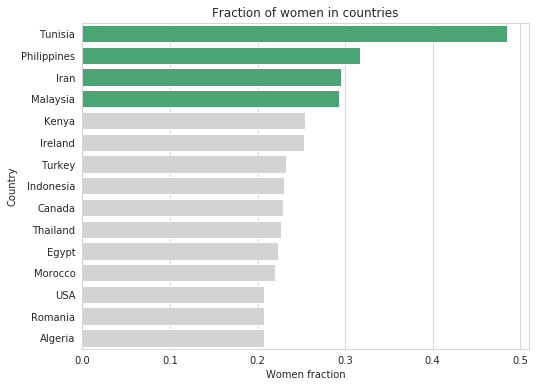

In [6]:
fig = plt.figure(figsize=(8, 6))
sns.barplot(data=df_country_count, 
            x='Women fraction', 
            y='index', 
            order=df_country_count['index'].iloc[:15],
            palette=[color_front for _ in range(4)] + [color_back for _ in range(11)])
plt.ylabel('Country')
plt.title('Fraction of women in countries');

# Gender ratio across roles

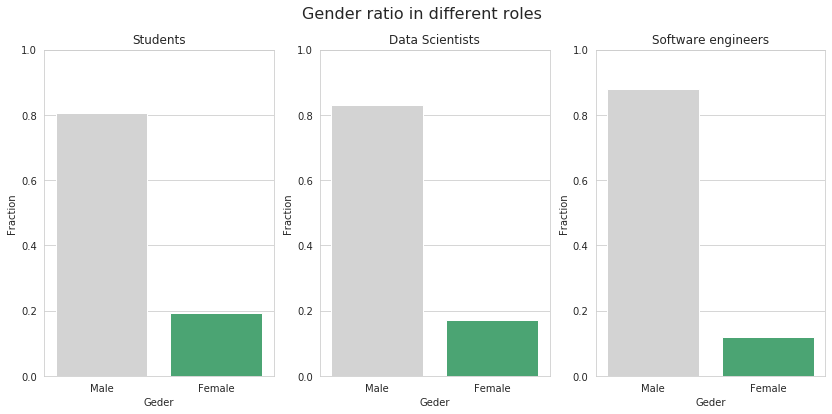

In [7]:
data_science_jobs = ['Data Scientist', 'Data Analyst', 'Research Scientist', 'Statistician']
df_ds_jobs = df.loc[df[job_title_col].isin(data_science_jobs)]
df_students = df.loc[df[job_title_col]=='Student']
se_jobs = ['Data Engineer', 'Software Engineer']
df_se_jobs = df.loc[df[job_title_col].isin(se_jobs)]

fig = plt.figure(figsize=(14, 6))

# Students
ax1 = fig.add_subplot(1, 3, 1)
sns.barplot(x='Gender', 
            y='Gender', 
            data=df_students, 
            estimator=lambda x: len(x) / len(df_students), 
            orient='v', 
            palette=[color_back, color_front, color_back, color_back])
ax1.set_xlabel('Geder')
ax1.set_ylabel('Fraction')
ax1.set_ylim(0.0, 1.0)
ax1.set_title('Students')

# Data Science
ax2 = fig.add_subplot(1, 3, 2)
sns.barplot(x='Gender', 
            y='Gender', 
            data=df_ds_jobs, 
            estimator=lambda x: len(x) / len(df_ds_jobs), 
            orient='v', 
            palette=[color_back, color_front, color_back, color_back])
ax2.set_xlabel('Geder')
ax2.set_ylabel('Fraction')
ax2.set_ylim(0.0, 1.0)
ax2.set_title('Data Scientists');

# Software engineering
ax3 = fig.add_subplot(1, 3, 3)
sns.barplot(x='Gender', 
            y='Gender', 
            data=df_se_jobs, 
            estimator=lambda x: len(x) / len(df_se_jobs), 
            orient='v', 
            palette=[color_back, color_front, color_back, color_back])
ax3.set_xlabel('Geder')
ax3.set_ylabel('Fraction')
ax3.set_ylim(0.0, 1.0)
ax3.set_title('Software engineers')
plt.suptitle('Gender ratio in different roles', fontsize=16);

# Women salaries

In [8]:
# Salary preprocessing
salary_column = 'What is your current yearly compensation (approximate $USD)?'
salary_type = CategoricalDtype(categories=["$0-999", "1,000-1,999", "2,000-2,999", "3,000-3,999", "4,000-4,999",
                                           "5,000-7,499", "7,500-9,999", "10,000-14,999", "15,000-19,999",
                                           "20,000-24,999", "25,000-29,999", "30,000-39,999", "40,000-49,999",
                                           "50,000-59,999", "60,000-69,999", "70,000-79,999", "80,000-89,999",
                                           "200,000-249,999", "250,000-299,999", "300,000-500,000", "> $500,000"],
                               ordered=True)
df[salary_column] = df[salary_column].astype(salary_type)

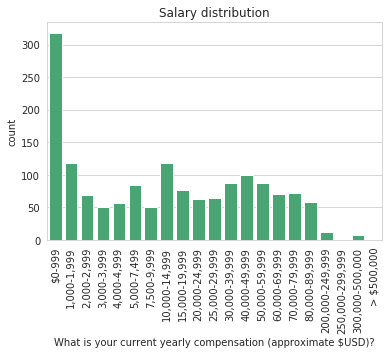

In [9]:
df_women = df.loc[df['Gender']=='Female', :]
sns.countplot(data=df_women, x=salary_column, color=color_front)
plt.xticks(rotation=90)
plt.title('Salary distribution');

# Sociodemographics

In [10]:
# Age preprocessing
age_column = 'What is your age (# years)?'
age_type = CategoricalDtype(categories=['18-21', '22-24', '25-29', '30-34', '35-39', '40-44', 
                                        '45-49', '50-54', '55-59', '60-69', '70+'], ordered=True)
df[age_column] = df[age_column].astype(age_type)

# Experience preprocessing
experience_column = 'How long have you been writing code to analyze data (at work or at school)?'
experience_type = CategoricalDtype(categories=['< 1 years', '1-2 years', '3-5 years', '5-10 years', 
                                               '10-20 years', '20+ years'], ordered=True)
df[experience_column] = df[experience_column].astype(experience_type)

# Education preprocessing
education_column = 'What is the highest level of formal education that you have attained or plan to attain within the next 2 years?'
df.loc[df[education_column]=='Some college/university study without earning a bachelor’s degree', education_column] = 'Some university study, no degree'

df_women = df.loc[df['Gender']=='Female', :]

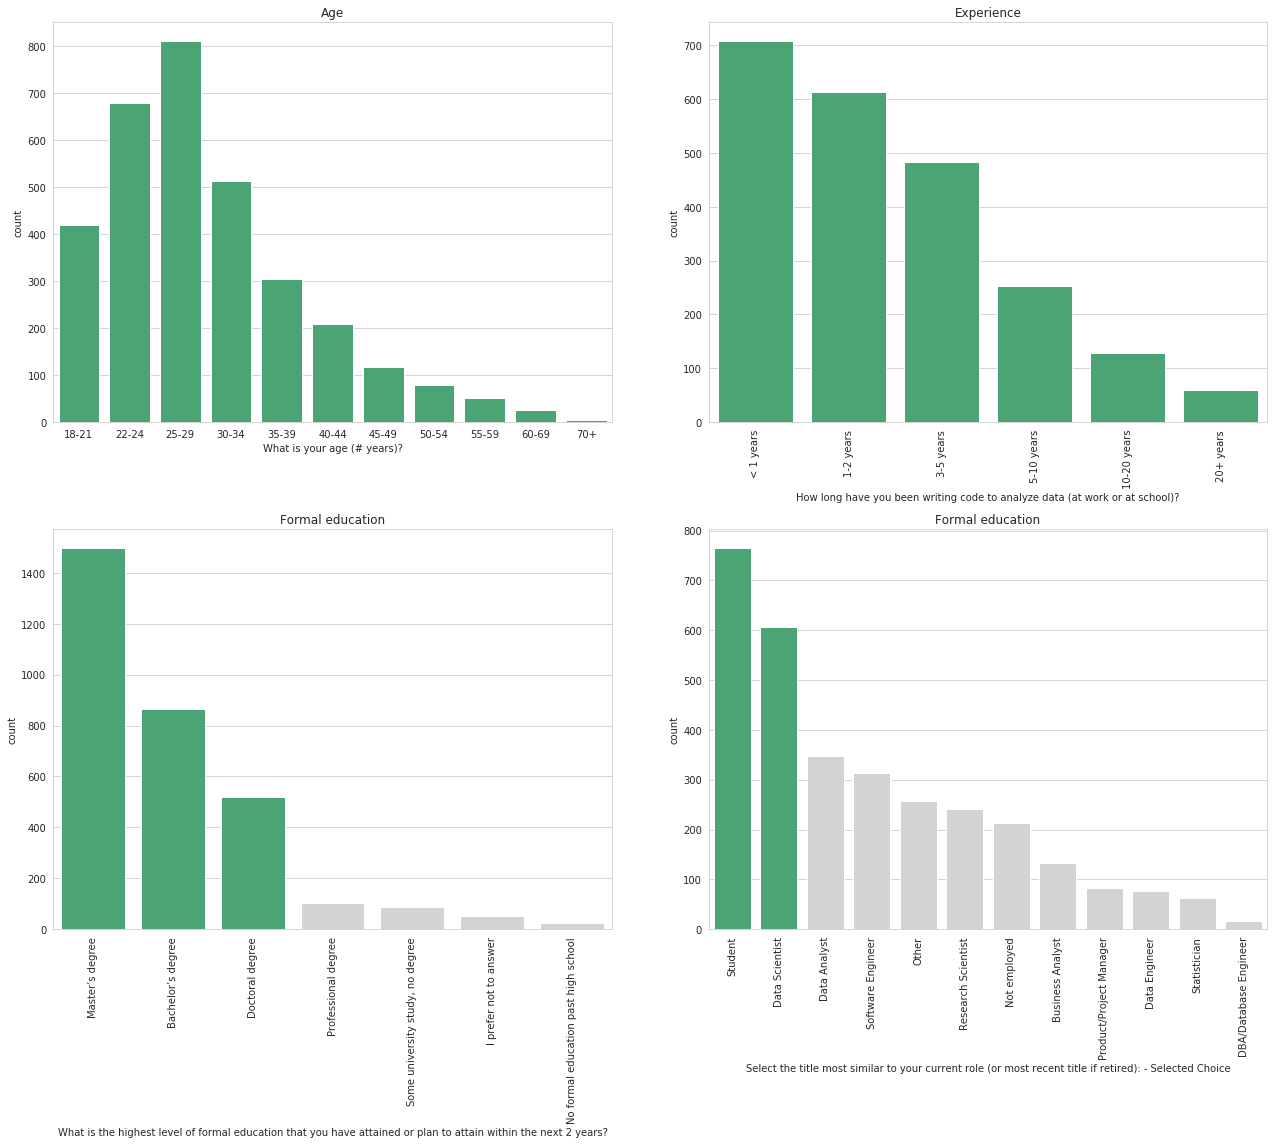

In [11]:
fig = plt.figure(figsize=(18, 16))

ax1 = fig.add_subplot(2, 2, 1)
sns.countplot(data=df_women, x=age_column, color=color_front)
ax1.set_title('Age')

ax2 = fig.add_subplot(2, 2, 2)
sns.countplot(data=df_women, x=experience_column, color=color_front)
ax2.set_title('Experience')
plt.xticks(rotation=90)

ax3 = fig.add_subplot(2, 2, 3)
sns.countplot(data=df_women, 
              x=education_column, 
              order=df_women[education_column].value_counts().index,
              palette=[color_front for _ in range(3)] + [color_back for _ in range(6)])
plt.xticks(rotation=90)
ax3.set_ylabel('count')
ax3.set_title('Formal education')

ax4 = fig.add_subplot(2, 2, 4)
sns.countplot(data=df_women, 
              x=job_title_col, 
              order=df_women[job_title_col].value_counts().index,
              palette=[color_front for _ in range(2)] + [color_back for _ in range(10)])
plt.xticks(rotation=90)
ax4.set_ylabel('count')
ax4.set_title('Formal education')

plt.tight_layout();

# Skills

In [12]:
# Create subsets of variable dedicated to skills, activities, programming languages etc.
ide_usage = ["Q16_Part_1", "Q16_Part_2", "Q16_Part_3", "Q16_Part_4", "Q16_Part_5", "Q16_Part_6", "Q16_Part_7", "Q16_Part_8", "Q16_Part_9", "Q16_Part_10"]
notebook_usage = ["Q17_Part_1", "Q17_Part_2", "Q17_Part_3", "Q17_Part_4", "Q17_Part_5", "Q17_Part_6", "Q17_Part_7", "Q17_Part_8", "Q17_Part_9", "Q17_Part_10"]
language_usage = ["Q18_Part_1", "Q18_Part_2", "Q18_Part_3", "Q18_Part_4", "Q18_Part_5", "Q18_Part_6", "Q18_Part_7", "Q18_Part_8", "Q18_Part_9", "Q18_Part_10"]
visual_usage = ["Q20_Part_1", "Q20_Part_2", "Q20_Part_3", "Q20_Part_4", "Q20_Part_5", "Q20_Part_6", "Q20_Part_7", "Q20_Part_8", "Q20_Part_9", "Q20_Part_10"]
algo_usage = ["Q24_Part_1", "Q24_Part_2", "Q24_Part_3", "Q24_Part_4", "Q24_Part_5", "Q24_Part_6", "Q24_Part_7", "Q24_Part_8", "Q24_Part_9", "Q24_Part_10"]
ml_tools_usage = ["Q25_Part_1", "Q25_Part_2", "Q25_Part_3", "Q25_Part_4", "Q25_Part_5", "Q25_Part_6"]
cv_usage = ["Q26_Part_1", "Q26_Part_2", "Q26_Part_3", "Q26_Part_4", "Q26_Part_5"]
nlp_usage = ["Q27_Part_1", "Q27_Part_2", "Q27_Part_3", "Q27_Part_4"]
ml_frameworks_usage = ["Q28_Part_1", "Q28_Part_2", "Q28_Part_3", "Q28_Part_4", "Q28_Part_5", "Q28_Part_6", "Q28_Part_7", "Q28_Part_8", "Q28_Part_9", "Q28_Part_10"]
cloud_platforms_usage = ["Q29_Part_1", "Q29_Part_2", "Q29_Part_3", "Q29_Part_4", "Q29_Part_5", "Q29_Part_6", "Q29_Part_7", "Q29_Part_8", "Q29_Part_9", "Q29_Part_10"]
cloud_products_usage = ["Q30_Part_1", "Q30_Part_2", "Q30_Part_3", "Q30_Part_4", "Q30_Part_5", "Q30_Part_6", "Q30_Part_7", "Q30_Part_8", "Q30_Part_9", "Q30_Part_10"]
big_data_products_usage = ["Q31_Part_1", "Q31_Part_2", "Q31_Part_3", "Q31_Part_4", "Q31_Part_5", "Q31_Part_6", "Q31_Part_7", "Q31_Part_8", "Q31_Part_9", "Q31_Part_10"]
ml_products_usage = ["Q32_Part_1", "Q32_Part_2", "Q32_Part_3", "Q32_Part_4", "Q32_Part_5", "Q32_Part_6", "Q32_Part_7", "Q32_Part_8", "Q32_Part_9", "Q32_Part_10"]
automl_tools = ["Q33_Part_1", "Q33_Part_2", "Q33_Part_3", "Q33_Part_4", "Q33_Part_5", "Q33_Part_6", "Q33_Part_7", "Q33_Part_8", "Q33_Part_9", "Q33_Part_10"]
db_tools = ["Q34_Part_1", "Q34_Part_2", "Q34_Part_3", "Q34_Part_4", "Q34_Part_5", "Q34_Part_6", "Q34_Part_7", "Q34_Part_8", "Q34_Part_9", "Q34_Part_10"]

gender_question = ["Q2"]

# Dataframe with skills related questions
df_skills = pd.read_csv('../data/raw/multiple_choice_responses.csv')
skills = [gender_question, ide_usage, notebook_usage, language_usage, visual_usage, algo_usage,
          ml_tools_usage, cv_usage, nlp_usage, ml_frameworks_usage,  cloud_platforms_usage, 
          big_data_products_usage, ml_products_usage, automl_tools, db_tools]
df_skills = df_skills.loc[:, np.concatenate(skills)]

# Questions as column names
df_skills.columns = df_skills.iloc[0]
df_skills.drop(df_skills.index[0], inplace=True)
df_skills = df_skills.reset_index(drop=True)

# Analize only female kagglers
df_skills = df_skills[df_skills['What is your gender? - Selected Choice']=='Female']
df_skills.drop(columns=['What is your gender? - Selected Choice'], inplace=True)

# Shorten column names - only a skill name
for c in df_skills.columns:
    column_name = c.split('Selected Choice - ')[-1].strip().split('(')[0]
    df_skills.rename(columns={c: column_name}, inplace=True)
    
# Binarize
df_skills[~df_skills.isnull()] = 1
df_skills[df_skills.isnull()] = 0
df_skills = df_skills.astype(np.int8)

# Discard rare skills
df_skills = df_skills.loc[:, df_skills.sum(axis=0) > 50]

# Discard users that haven't chosen at least 5 skills
df_skills = df_skills[df_skills.sum(axis=1) > 5]

df_skills.head()

,Jupyter,RStudio,PyCharm,Atom,MATLAB,Visual Studio / Visual Studio Code,Spyder,Vim / Emacs,Notepad++,Sublime Text,Kaggle Notebooks,Google Colab,Microsoft Azure Notebooks,Google Cloud Notebook Products,Binder / JupyterHub,IBM Watson Studio,AWS Notebook Products,Python,R,SQL,C,C++,Java,Javascript,Bash,MATLAB,Ggplot / ggplot2,Matplotlib,Shiny,D3.js,Plotly / Plotly Express,Bokeh,Seaborn,Geoplotlib,Leaflet / Folium,Linear or Logistic Regression,Decision Trees or Random Forests,Gradient Boosting Machines,Bayesian Approaches,Evolutionary Approaches,Dense Neural Networks,Convolutional Neural Networks,Generative Adversarial Networks,Recurrent Neural Networks,Transformer Networks,Automated data augmentation,Automated feature engineering/selection,Automated model selection,Automated model architecture searches,Automated hyperparameter tuning,Automation of full ML pipelines,General purpose image/video tools,Image segmentation methods,Object detection methods,Image classification and other general purpose networks,Generative Networks,Word embeddings/vectors,Encoder-decorder models,Contextualized embeddings,Transformer language models,Scikit-learn,TensorFlow,Keras,RandomForest,Xgboost,PyTorch,Caret,LightGBM,Spark MLib,Fast.ai,Google Cloud Platform,Amazon Web Services,Microsoft Azure,IBM Cloud,Google BigQuery,AWS Redshift,Databricks,Teradata,Microsoft Analysis Services,Google Cloud Dataflow,SAS,Cloudera,Azure Machine Learning Studio,Google Cloud Machine Learning Engine,Google Cloud Speech-to-Text,Google Cloud Natural Language,Auto-Keras,Auto-Sklearn,MySQL,PostgresSQL,SQLite,Microsoft SQL Server,Oracle Database,Microsoft Access,AWS Relational Database Service,Azure SQL Database,Google Cloud SQL
7,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
20,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
28,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
29,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
skills_matrix = scipy.sparse.csr_matrix(df_skills.values)
BG = nx.algorithms.bipartite.matrix.from_biadjacency_matrix(skills_matrix)
bipartite.is_bipartite(BG)

True

In [14]:
partitions = bipartite.sets(BG)
users_partition = partitions[0]
skills_partition = partitions[1]

UG = bipartite.weighted_projected_graph(BG, users_partition)

In [16]:
UG_filtered = nx.Graph()

for edge in tqdm.tqdm_notebook(UG.edges(data=True)):  
    u, v, weight = edge
    weight = weight['weight']

    if weight > 5:
        UG_filtered.add_edge(u, v, weight=weight)
        
del UG

In [17]:
print(f'Number of nodes in the female kagglers graph: {UG_filtered.order()}')
print(f'Number of edges in the female kagglers graph: {UG_filtered.size()}')

Number of nodes in the female kagglers graph: 1960
Number of edges in the female kagglers graph: 996011


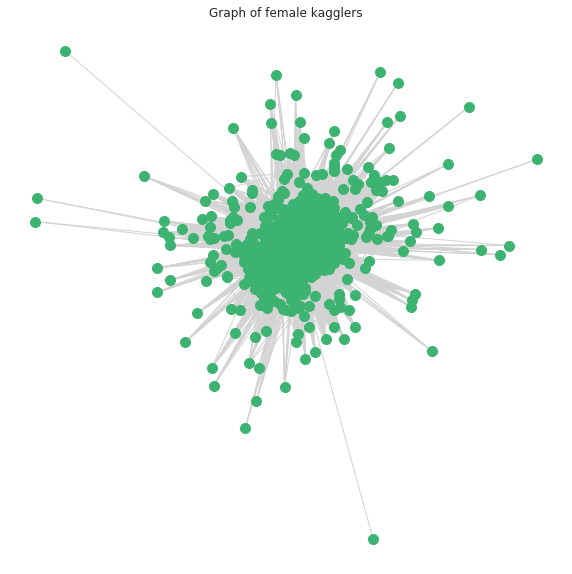

In [18]:
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(UG_filtered)
nx.draw_networkx_nodes(UG_filtered, pos, node_color=color_front, node_size=100)
nx.draw_networkx_edges(UG_filtered, pos, edge_color=color_back)
plt.title('Graph of female kagglers')
plt.axis('off');

Average clustering: 0.859
Average shortest paths: 1.481


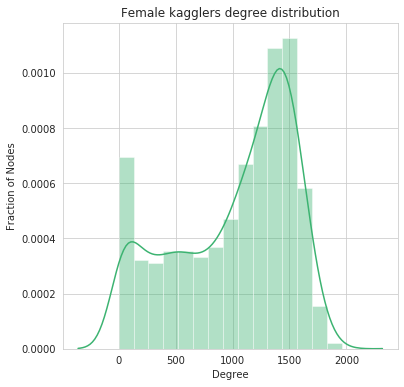

In [19]:
print(f'Average clustering: {round(nx.average_clustering(UG_filtered), 3)}')
print(f'Average shortest paths: {round(nx.average_shortest_path_length(UG_filtered), 3)}')

figure = plt.figure(figsize=(6, 6))
ax = plt.axes()

degrees = list(dict(UG_filtered.degree()).values())
sns.distplot(degrees, norm_hist=True, color=color_front)
plt.xlabel('Degree')
plt.ylabel('Fraction of Nodes')
plt.title('Female kagglers degree distribution')
plt.show();

# Skills of female kagglers

In [61]:
# Create skills graph, label the nodes with skills name
SG = bipartite.weighted_projected_graph(BG, skills_partition)
for i, name in enumerate(dict(SG.nodes()).keys()):
    SG.nodes[name]['label'] = df_skills.columns[i]

SG_filtered = nx.Graph()

for edge in tqdm.tqdm_notebook(SG.edges(data=True)):  
    u, v, weight = edge
    weight = weight['weight']

    if weight > 100:
        SG_filtered.add_edge(u, v, weight=weight)

print(f'Number of nodes in the skills graph: {SG.order()}')
print(f'Number of edges in the skills graph: {SG.size()}')


Number of nodes in the skills graph: 97
Number of edges in the skills graph: 4656


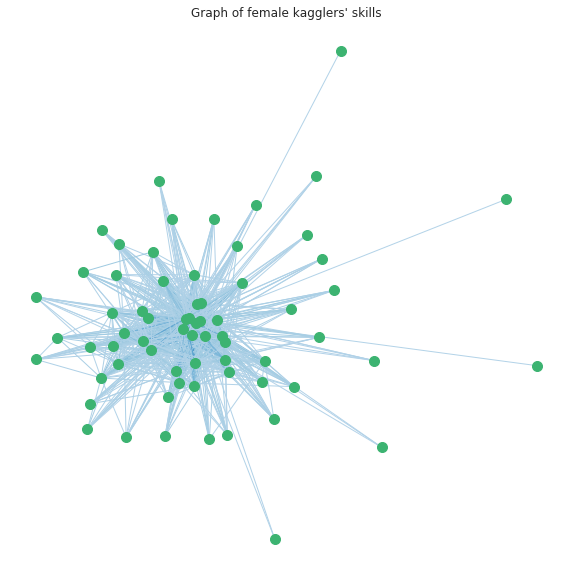

In [62]:
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(SG_filtered)
nx.draw_networkx_nodes(SG_filtered, pos, node_color=color_front, node_size=100)

edge_color = [attr['weight'] for u, v, attr in SG_filtered.edges(data=True)]
nx.draw_networkx_edges(SG_filtered, 
                       pos, 
                       edge_color=edge_color,
                       edge_vmin=-500,
                       edge_vmax=max(edge_color),
                       edge_cmap=plt.cm.Blues)
plt.title('Graph of female kagglers\' skills')
plt.axis('off');

Average clustering: 0.824
Average shortest paths: 1.649


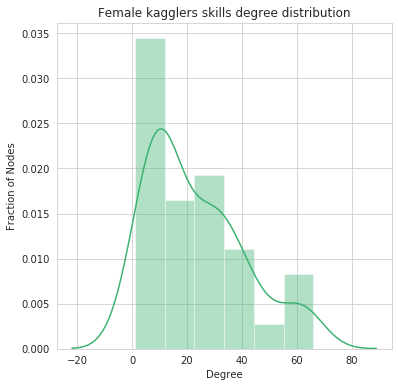

In [63]:
print(f'Average clustering: {round(nx.average_clustering(SG_filtered), 3)}')
print(f'Average shortest paths: {round(nx.average_shortest_path_length(SG_filtered), 3)}')
figure = plt.figure(figsize=(6, 6))
ax = plt.axes()

degrees = list(dict(SG_filtered.degree()).values())
sns.distplot(degrees, norm_hist=True, color=color_front)
plt.xlabel('Degree')
plt.ylabel('Fraction of Nodes')
plt.title('Female kagglers skills degree distribution')
plt.show();